# Exploratory Data Analysis

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.patches as patches
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_columns', 150)

Reading in dataframe from the preprocessing step

In [3]:
df = pd.read_csv('Data/result1.csv')

First we'll look at the statistics involved when looking at the best and worst pitcher based on our metric the strike_result. Remember we'll only be looking at starting pitchers so we have to filter out relief pitchers and closers to find the best and worst starting pitchers.


In [4]:
# We will filter out any pitchers that haven't pitched in the first inning before
starting_pitchers_names = df.player_name.loc[df['inning']==1].unique()
starting_pitchers = (df.loc[df.player_name.isin(starting_pitchers_names)]
                        .groupby('player_name')
                        .agg({'release_speed':'mean',
                              'strike_result':'mean',
                              'at_bat_number':'count',
                              'pitch_name':lambda x:x.value_counts().index[0],
                              'release_pos_x':'mean',
                              'release_pos_y':'mean',
                              'release_pos_z':'mean',
                              'release_extension':'mean',
                              'pfx_x':'mean',
                              'pfx_z':'mean'})
                        .sort_values(by='strike_result', ascending=False))
best_pitchers = starting_pitchers.head(20)
worst_pitchers = starting_pitchers.tail(20)
pd.concat([best_pitchers, worst_pitchers], axis='rows')



,release_speed,strike_result,at_bat_number,pitch_name,release_pos_x,release_pos_y,release_pos_z,release_extension,pfx_x,pfx_z
player_name,,,,,,,,,,
Max Scherzer,89.140670,0.708134,209,4-Seam Fastball,-3.444684,54.670836,5.340946,5.828665,-0.463185,0.600982
Bryse Wilson,92.304938,0.691358,81,4-Seam Fastball,-3.299284,54.321744,5.513777,6.177728,-0.547493,0.921809
Noe Ramirez,82.668831,0.688312,77,Curveball,-2.411816,55.078836,4.922806,5.420675,-0.060570,0.070838
Patrick Corbin,87.595000,0.670000,100,2-Seam Fastball,2.454508,54.300999,6.425273,6.198540,0.652549,0.677704
David Price,88.556250,0.666667,96,Changeup,3.481049,54.719951,5.745940,5.779500,1.112675,0.816492
Matt Strahm,86.793827,0.666667,81,4-Seam Fastball,2.367935,54.779242,5.177252,5.720272,0.378959,0.601133
Brendan McKay,89.965432,0.666667,81,4-Seam Fastball,1.014185,54.317415,6.029983,6.182099,0.195916,0.884220
Aaron Nola,85.303977,0.664773,176,Knuckle Curve,-1.798791,54.061258,4.890887,6.438244,-0.273872,0.055513
Chris Paddack,89.791160,0.657459,181,4-Seam Fastball,-2.495464,53.703017,6.275098,6.796514,-0.575067,1.121038


As seen above, Max Scherzer is our 'best' pitcher, and Mike Clevinger our 'worst'.

In [5]:
# filtering out non-starters and sorting events into chronological order
game_stats = (df.loc[df.player_name.isin(starting_pitchers_names)]
                   .sort_values(['game_pk','inning', 'inning_topbot', 'outs_when_up', 'at_bat_number', 'pitch_number'],
                         ascending=[False, True, False, True, True, True]))

# aggregating performance of each pitcher into games played into number of innings played and how many points given
season_stats = (game_stats.groupby(['game_pk', 'player_name'])
                          .agg({'bat_score':lambda x: x.max() - x.min(),
                                'inning': lambda x: x.max() - x.min() + 1}))

# creating a feature called ERA (Earned Run Average) representing the number of runs given for the season so far.
season_stats['ERA'] = round(season_stats['bat_score']*9 / season_stats['inning'], 2)
season_stats = season_stats.groupby('player_name').agg({'ERA':'mean', 'inning':'sum'}).sort_values('ERA').head()


low_era_pitchers = (df.loc[df.player_name.isin(season_stats.index)]
                        .groupby('player_name')
                        .agg({'release_speed':'mean',
                              'strike_result':'mean',
                              'at_bat_number':'count',
                              'pitch_name':lambda x:x.value_counts().index[0],
                              'release_pos_x':'mean',
                              'release_pos_y':'mean',
                              'release_pos_z':'mean',
                              'release_extension':'mean',
                              'pfx_x':'mean',
                              'pfx_z':'mean'})
                        .sort_values(by='strike_result', ascending=False))

low_era_pitchers


,release_speed,strike_result,at_bat_number,pitch_name,release_pos_x,release_pos_y,release_pos_z,release_extension,pfx_x,pfx_z
player_name,,,,,,,,,,
Daniel Mengden,86.002151,0.645161,93,4-Seam Fastball,-1.611784,54.275319,5.885624,6.224161,-0.150159,0.733908
John Means,87.236145,0.614458,83,4-Seam Fastball,0.680183,54.638670,6.519657,5.860867,0.578743,1.417798
Chad Green,94.703571,0.607143,28,4-Seam Fastball,-2.101182,54.310464,5.913082,6.189000,-0.452057,1.132879
Matt Carasiti,94.151111,0.555556,45,Sinker,-2.064160,54.666064,6.035233,5.833333,-0.977502,0.820591
Aaron Civale,86.677907,0.511628,86,Sinker,-1.305345,55.185731,6.018490,5.313802,-0.232423,0.449184


We will now compare 3 pitchers with very different skill levels. Max Scherzer who has the best strike rate, Marcus Stroman who is the highest paid pitcher on the Blue Jays, and Mike Clevinger who is worst performing pitcher this year. By grouping the different pitches that these pitchers can use, we can discover subtle differences between them.

In [6]:
player_comparison = (df[df.player_name.isin(['Max Scherzer', 'Mike Clevinger', 'Marcus Stroman'])]
 .groupby(['pitch_name','player_name'])
 .agg({'release_speed':'mean',          
      'at_bat_number':'count',
      'pitch_name':lambda x:x.value_counts().index[0],
       'vx0':'mean',
       'vy0':'mean',
       'vz0':'mean',
       'ax':'mean',
       'ay':'mean',
      'release_pos_x':'mean',
      'release_pos_y':'mean',
      'release_pos_z':'mean',
      'release_extension':'mean',
      'release_spin_rate':'mean',
      'pfx_x':'mean',
      'pfx_z':'mean',
      'strike_result':'mean'})
)
player_comparison

release_speed  at_bat_number       pitch_name  \
pitch_name      player_name                                                     
2-Seam Fastball Marcus Stroman      92.662500             40  2-Seam Fastball   
4-Seam Fastball Marcus Stroman      93.085714              7  4-Seam Fastball   
                Max Scherzer        95.295455             88  4-Seam Fastball   
                Mike Clevinger      96.303704             27  4-Seam Fastball   
Changeup        Marcus Stroman      87.600000              3         Changeup   
                Max Scherzer        83.939394             33         Changeup   
                Mike Clevinger      90.000000              8         Changeup   
Curveball       Marcus Stroman      73.600000              2        Curveball   
                Max Scherzer        78.418750             16        Curveball   
                Mike Clevinger      77.788889              9        Curveball   
Cutter          Marcus Stroman      91.356000             50           Cutter   
                Max Scherzer        89.911765             17           Cutter   
Slider          Marcus Stroman      86.560294             68           Slider   
                Max Scherzer        85.294545             55           Slider   
                Mike Clevinger      80.562500              8           Slider   

                                      vx0         vy0       vz0         ax  \
pitch_name      player_name                                                  
2-Seam Fastball Marcus Stroman   4.983645 -134.841375 -3.036985 -12.799878   
4-Seam Fastball Marcus Stroman   4.994429 -135.464014 -2.810429  -4.630743   
                Max Scherzer    11.162019 -138.214139 -4.728298 -14.924670   
                Mike Clevinger   4.045226 -140.220889 -5.986300  -6.778993   
Changeup        Marcus Stroman   6.422133 -127.414767 -4.200467 -11.496633   
                Max Scherzer     9.068003 -121.845679 -2.803448 -14.309473   
                Mike Clevinger   5.507850 -131.048587 -5.709325 -13.030487   
Curveball       Marcus Stroman   2.444750 -106.927200 -1.494700   8.536800   
                Max Scherzer     4.471944 -114.077500  0.748044   7.170719   
                Mike Clevinger  -0.632089 -113.185689  1.228133   8.352656   
Cutter          Marcus Stroman   5.143366 -132.916132 -1.918036  -0.327896   
                Max Scherzer    10.041453 -130.517847 -4.484559  -1.294006   
Slider          Marcus Stroman   3.444304 -125.945756 -1.957790   7.148404   
                Max Scherzer     8.651307 -123.850404 -1.478180   1.413389   
                Mike Clevinger  -0.439412 -117.269825 -0.441037  14.707512   

                                       ay  release_pos_x  release_pos_y  \
pitch_name      player_name                                               
2-Seam Fastball Marcus Stroman  25.760488      -1.400732      54.804125   
4-Seam Fastball Marcus Stroman  26.453929      -1.206557      54.679386   
                Max Scherzer    29.418499      -3.393165      54.615100   
                Mike Clevinger  30.679911      -1.624515      53.804385   
Changeup        Marcus Stroman  23.084800      -1.394967      54.758800   
                Max Scherzer    22.829933      -3.469291      54.626206   
                Mike Clevinger  24.670412      -1.454425      53.595487   
Curveball       Marcus Stroman  17.656050      -1.531800      56.159600   
                Max Scherzer    19.181556      -3.344212      54.949613   
                Mike Clevinger  19.815867      -1.253789      54.758756   
Cutter          Marcus Stroman  25.126082      -1.411634      54.932766   
                Max Scherzer    24.485988      -3.466041      54.716247   
Slider          Marcus Stroman  23.120596      -1.446850      55.100301   
                Max Scherzer    24.174227      -3.534978      54.691658   
                Mike Clevinger  21.951837      -1.565788      54.574463   

                                release_pos_z  rele

Speed doesn't seem to be the most important factor that determines a strike as generally assumed. Mike Clevinger's 4-seam fastball release speed seems to be the fastest, but simultaneously the worst performaning amongst the two other pitchers. One important difference observed is the vx0, and ax0 features are significantly greater for Max Scherzer compared to the other two pitchers. It is possible that a high vx0, and ax0 attribute to a higher strike chance. 

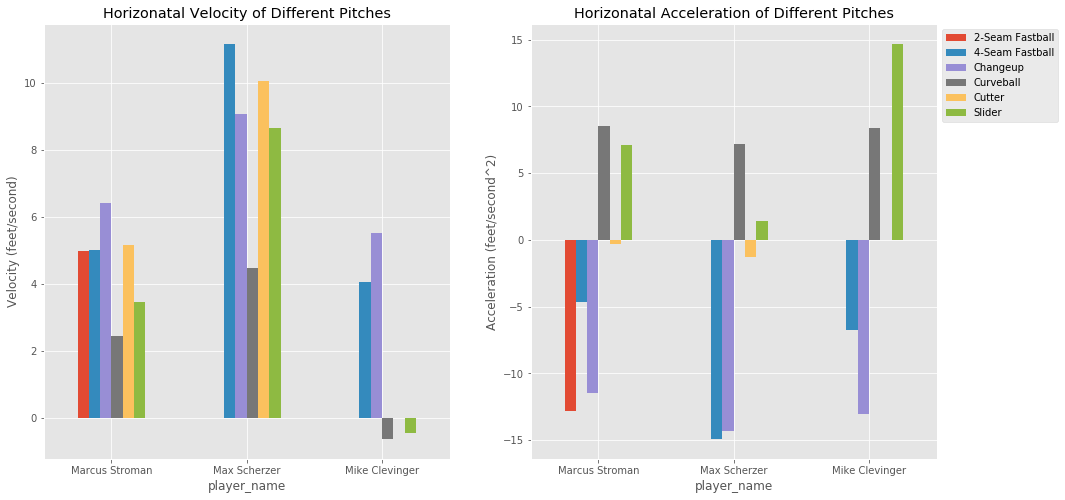

In [7]:
fig3, (ax3, ax4) = plt.subplots(1,2, figsize=(16,8))

_ = player_comparison['vx0'].unstack(level=0).plot(kind='bar', rot=0, ax=ax3, legend=False)
_ = ax3.set_title('Horizonatal Velocity of Different Pitches')
_ = ax3.set_ylabel('Velocity (feet/second)')

_ = player_comparison['ax'].unstack(level=0).plot(kind='bar', rot=0, ax=ax4)
_ = ax4.set_title('Horizonatal Acceleration of Different Pitches')
_ = ax4.set_ylabel('Acceleration (feet/second^2)')
_ = plt.legend(bbox_to_anchor=(1,1), loc='upper left')

One intersting oberservation above is that Max's 4-seam fastball and changeup are the most identical in terms of vx0 and particularly ax0. Given that Max's success rate for the changeup is the highest at a 75.7% mark, this may be a large contributing factor. What this would mean is that Max is successfully tricking batters into thinking he's about to throw a 4-seam fastball when he's throwing a changeup or vice versa, based on the way he swings out his arm.

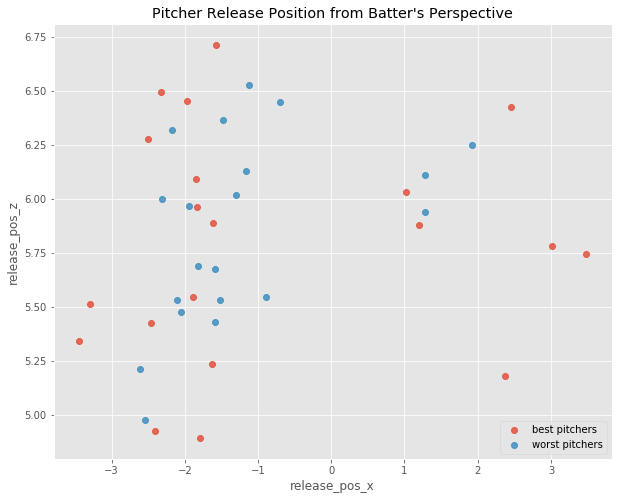

In [9]:

#_ = sns.regplot('release_pos_x', 'release_pos_z', data=low_era_pitchers, fit_reg=False, label='low era pitchers')
plt.figure(figsize=(10,8))
_ = sns.regplot('release_pos_x', 'release_pos_z', data=best_pitchers, fit_reg=False, label='best pitchers')
_ = sns.regplot('release_pos_x', 'release_pos_z', data=worst_pitchers, fit_reg=False, label='worst pitchers')
_ = plt.title('Pitcher Release Position from Batter\'s Perspective')
_ = plt.legend(loc='lower right')

For ease of understanding, imagine the pitcher standing where x-axis equals zero, and the point of release is where the dot lies on the plot. The difference in the horizonatal release points between the good and bad pitchers is a really interesting pattern. From this observation we can hypothesize that pitchers who release the ball further from their bodies have higher success rate of striking out batters. Height and arm length may be a big contributing factor in release_pos_x as well.

Note: negative values of release_pos_x represent right handed pitchers and postive x values correspond to left handers

''

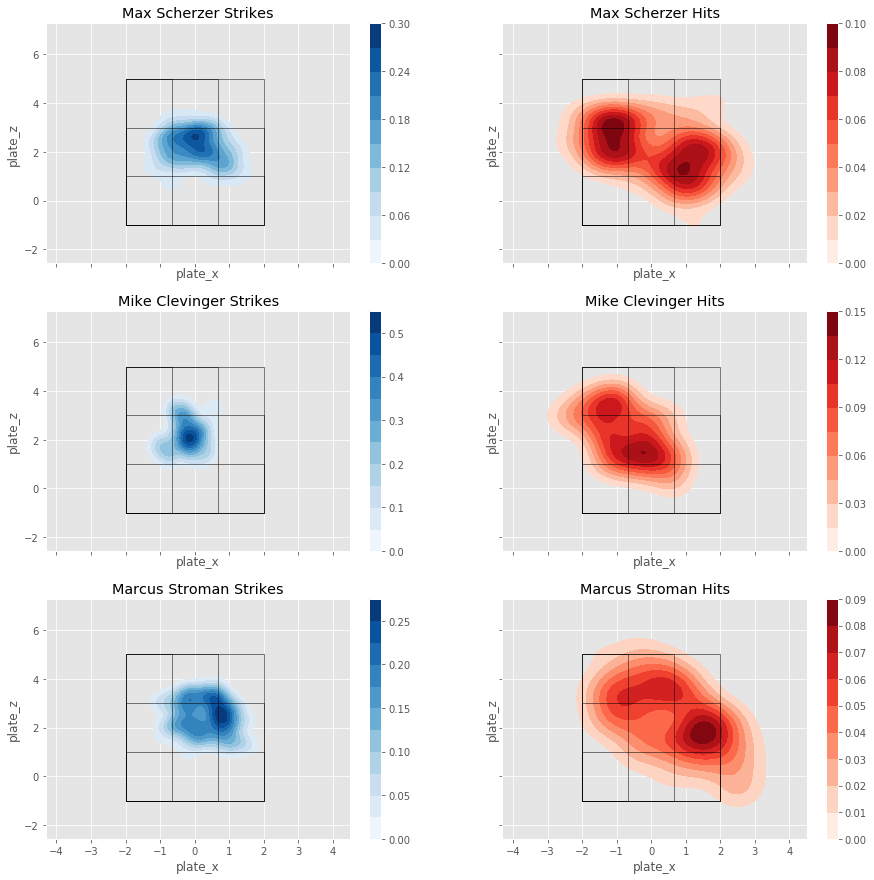

In [10]:
scherzer_strikes = df[(df['player_name']=='Max Scherzer')  & (df.strike_result==1)]
clevinger_strikes = df[(df['player_name']=='Mike Clevinger')  & (df.strike_result==1)]
stroman_strikes = df[(df['player_name']=='Marcus Stroman')  & (df.strike_result==1)]
scherzer_hits = df[(df['player_name']=='Max Scherzer') & (df.strike_result==0)]
clevinger_hits = df[(df['player_name']=='Mike Clevinger') & (df.strike_result==0)]
stroman_hits = df[(df['player_name']=='Marcus Stroman') & (df.strike_result==0) ]


fig, ax = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(15,15))

for i in range(0,3):
    for j in range(0,2):
        ax[i,j].add_patch(patches.Rectangle((-2, -1), 4, 6, fill=False, edgecolor='black'))
        ax[i,j].add_patch(patches.Rectangle((-2, -1), 4, 4, fill=False, edgecolor='black'))
        ax[i,j].add_patch(patches.Rectangle((-2, -1), 4, 2, fill=False, edgecolor='black'))
        ax[i,j].add_patch(patches.Rectangle((-2, -1), (4/3), 6, fill=False, edgecolor='black'))
        ax[i,j].add_patch(patches.Rectangle((-2, -1), (8/3), 6, fill=False, edgecolor='black'))

sns.kdeplot(scherzer_strikes['plate_x'] , scherzer_strikes['plate_z'], cmap="Blues", shade=True, shade_lowest=False, ax=ax[0,0], cbar=True).set_title('Max Scherzer Strikes')
sns.kdeplot(clevinger_strikes['plate_x'] , clevinger_strikes['plate_z'], cmap="Blues", shade=True, shade_lowest=False, ax=ax[1,0], cbar=True).set_title('Mike Clevinger Strikes')
sns.kdeplot(stroman_strikes['plate_x'] , stroman_strikes['plate_z'], cmap="Blues", shade=True, shade_lowest=False, ax=ax[2,0], cbar=True).set_title('Marcus Stroman Strikes')

sns.kdeplot(scherzer_hits['plate_x'] , scherzer_hits['plate_z'], cmap="Reds", shade=True, shade_lowest=False, ax=ax[0,1], cbar=True).set_title('Max Scherzer Hits')
sns.kdeplot(clevinger_hits['plate_x'] , clevinger_hits['plate_z'], cmap="Reds", shade=True, shade_lowest=False, ax=ax[1,1], cbar=True).set_title('Mike Clevinger Hits')
sns.kdeplot(stroman_hits['plate_x'] , stroman_hits['plate_z'], cmap="Reds", shade=True, shade_lowest=False, ax=ax[2,1], cbar=True).set_title('Marcus Stroman Hits')
;

Max and Marcus seems to have a larger distribution that spreads across zones 4,5,6 whereas the worst pitcher(Mike) has a smaller distribution concentrated around zone 5. This may be a major contributing factor towards a pitcher's success.

#### There are a few interesting hypothesis that can be drawn from the two graphs seen above:          
1) higher release_pos_x (aka greater height/longer arms) is directly related to the likelihood of throwing a strike     
2) A more varied toolbox of different pitches can result in more strikes     
3) The more similar the fastball and changeup pitches look (in terms of vx0, ax0), the more successful they can be at striking batters out          
4) The more zones the pitcher can pitch to can lead to a higher chance to striking the batter out